In [1]:
import os
import time
from tqdm import tqdm
from collections import Counter
import gzip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(0)

# LSH+K-means for clustering

##  Functions
### Shingles and One-hot encoding Functions

In [2]:
def build_shingles(sentence: str, k: int):
    shingles = []
    for i in range(len(sentence) - k):
        shingles.append(sentence[i:i+k])
    return set(shingles)

def build_vocab(shingle_sets: list):
    # convert list of shingle sets into single set
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

def build_vocab_high_rate(shingle_sets: list, threshold: int):
    vocab = {}
    for set_ in shingle_sets:
        for item in set_:
            if item not in vocab:
                vocab[item]=0
            
            vocab[item]+=1
    
    new_vocab = {}
    i = 0
    ks = vocab.keys()
    for k in ks:
        if vocab[k]>threshold:
            new_vocab[k] = i
            i += 1
    
    return new_vocab

def one_hot(shingles: set, vocab: dict):
    vec = np.zeros(len(vocab))
    for shingle in shingles:
        if shingle in vocab:
            idx = vocab[shingle]
            vec[idx] = 1
    return vec

### Minhash functions

In [3]:
def minhash_arr(vocab: dict, resolution: int):
    length = len(vocab.keys())
    arr = np.zeros((resolution, length))
    
    print("Minhash Transforming.............")
    for i in tqdm(range(resolution)):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
        
    return arr.astype(int)

def get_signature(minhash, vector):
    # get index locations of every 1 value in vector
    idx = np.nonzero(vector)[0].tolist()
    # use index locations to pull only +ve positions in minhash
    shgles = minhash[:, idx]
    # find minimum value in each hash vector
    try:
        signature = np.min(shgles, axis=1)
    except Exception:
        signature = np.zeros(40)
    return signature

### LSH class

In [4]:
from itertools import combinations

class LSH:
    buckets = []
    counter = 0
    def __init__(self, b):
        self.b = b
        for i in range(b):
            self.buckets.append({})

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = int(l / self.b)
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)
    
    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            subvec = ','.join(subvec)
            if subvec not in self.buckets[i].keys():
                self.buckets[i][subvec] = []
            self.buckets[i][subvec].append(self.counter)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for bucket_band in tqdm(self.buckets):
            keys = bucket_band.keys()
            for bucket in keys:
                hits = bucket_band[bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

## Dealing with data

### Load dataset

In [5]:
df = pd.read_csv("../test_data/DS_001.csv",sep='|', header=None)

In [6]:
print("We totally have {0} rows\n\n".format(len(df)))
print("---------------------------------------------------   Example data   -----------------------------------------------\n\n")
df.head(5)

We totally have 999992 rows


---------------------------------------------------   Example data   -----------------------------------------------




,0,1,2,3,4,5,6,7
0,136423,Customer#000136423,px9opIpsHkisumzUXhkzUxcRyX3,19,29-183-870-2573,4656.19,FURNITURE,carefully even dependencies nag quickly bold s...
1,136431,Customer#000136431,"FMreyxfcwXEoXJE06DOBkRZA,nYDrfo,",23,33-589-718-3186,60.83,BUILDING,requests after the quickly ironic tithes
2,136439,Customer#000136439,"DMTJQkFK,Ga1gYLX6tU FW5bHWEP2lQHGhoP08G",3,13-850-149-6111,8849.54,HOUSEHOLD,blithely regular pinto beans cajole
3,136447,Customer#000136447,mTsP4HsccF5V0pDk3hY0SSV8pvUvsQgBLXePb,19,29-513-812-2333,2612.90,AUTOMOBILE,"even, pending pinto beans according to the unus"
4,136455,Customer#000136455,Ca3N9yoltRaQsqheN79UbEirawmRX44Ma,17,27-983-956-4359,1575.19,FURNITURE,"fluffy deposits alongside of the final, special"


### Tuning parameters

In [7]:
# shingle size ------- similar to n-gram 
k = 3
# select a column
column = 8
# resolution: how many hash functions
resolution = 10
# b: busket number when using LSH
bk = 5

In [8]:
sentences = []
with open("../test_data/DS_001.csv") as f:
    for eachline in f:
        sentences.append(eachline)

### construct shingles and vocabulary dictionary

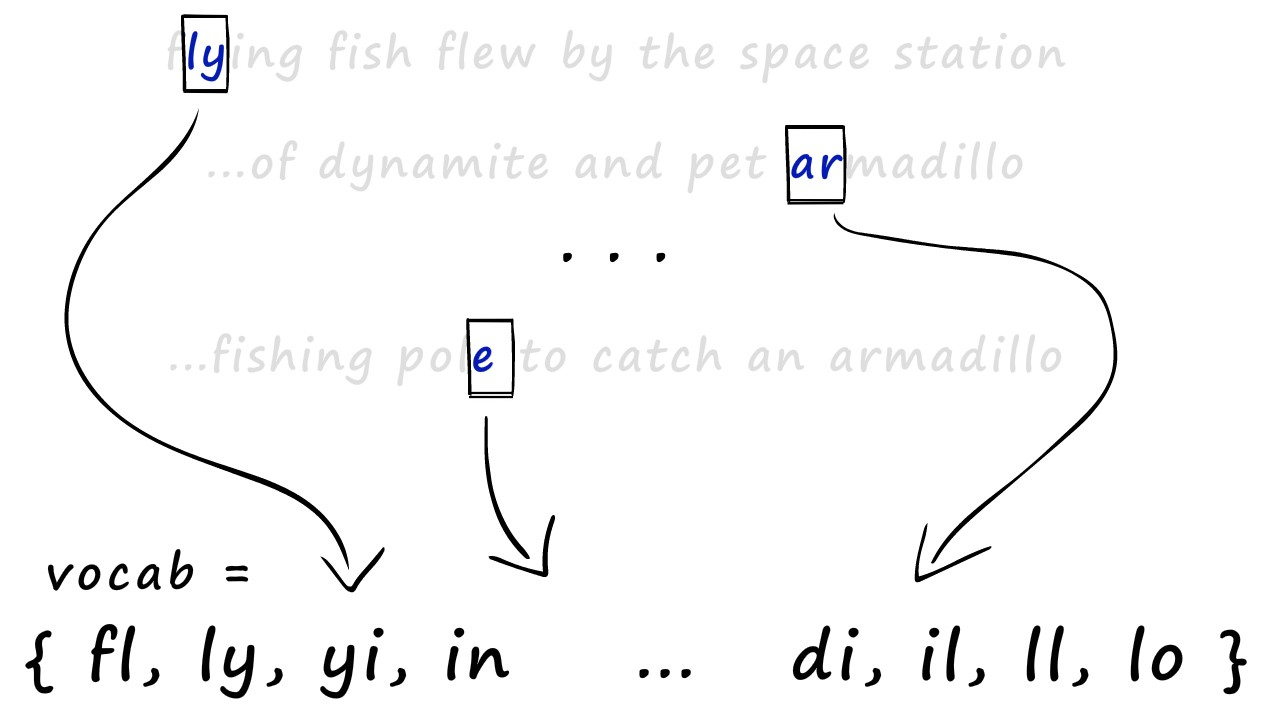

In [9]:
# sentences = test_tuples

In [10]:
#sentences = df[column].tolist()

st = time.time()
# build shingles
shingles = []
print("Building shingles and vocabulary dictionary")
for sentence in tqdm(sentences):
    shingles.append(build_shingles(sentence, k))

# build vocab
vocab = build_vocab_high_rate(shingles, 1)

et = time.time()
print('Execution time:', et-st-1, 'seconds')

Building shingles and vocabulary dictionary


100%|████████████████████████████████████████████████████████████████████████| 999992/999992 [03:19<00:00, 5008.64it/s]


Execution time: 358.6684081554413 seconds


In [11]:
len(vocab)

272656

# Construct one-hot vectors

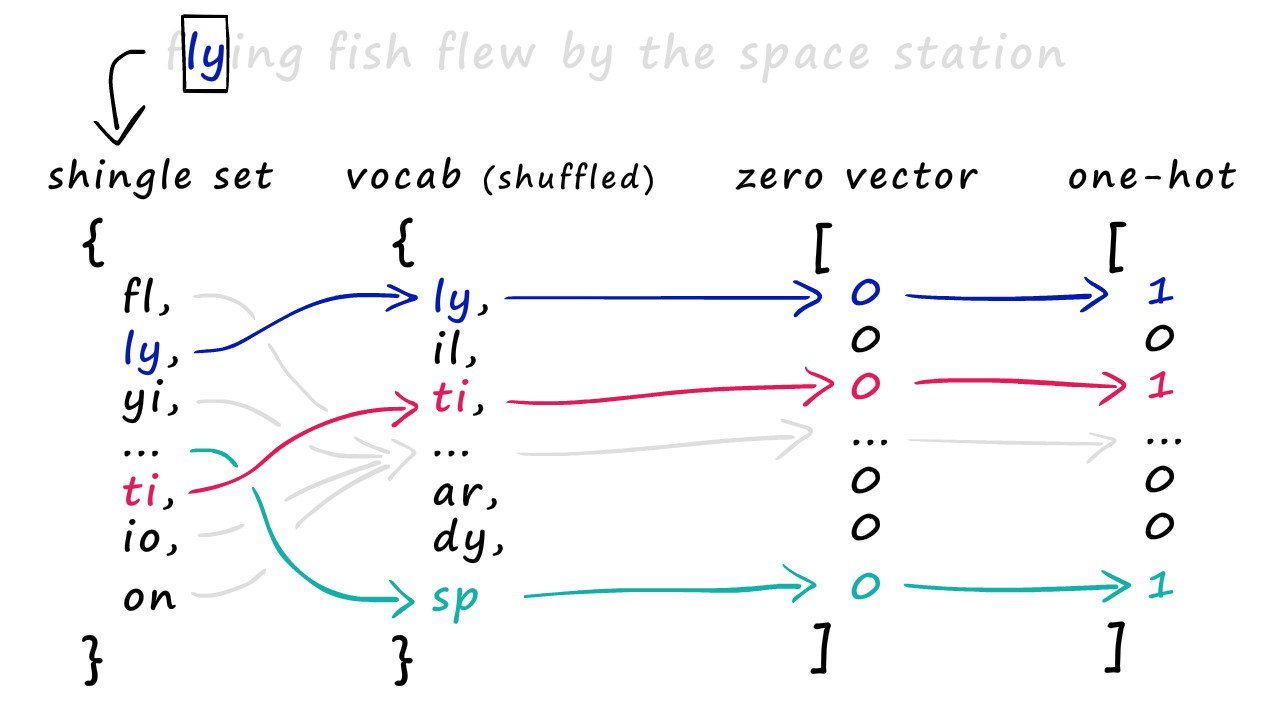

In [ ]:
# one-hot encode our shingles
# shingles_1hot = []

print("Building one-hot vector")

arr = minhash_arr(vocab, resolution)

signatures = []

st = time.time()
for shingle_set in tqdm(shingles):
    signatures.append(get_signature(arr, one_hot(shingle_set, vocab)))
# stack into single numpy array

print("vector stacking.......")
signatures = np.stack(signatures)

et = time.time()

print('Execution time:', et-st, 'seconds')
#print("one-hot vector of the given dataset is a {0}x{1} matrix\n".format(shingles_1hot.shape[0], shingles_1hot.shape[1]))

### Minhash

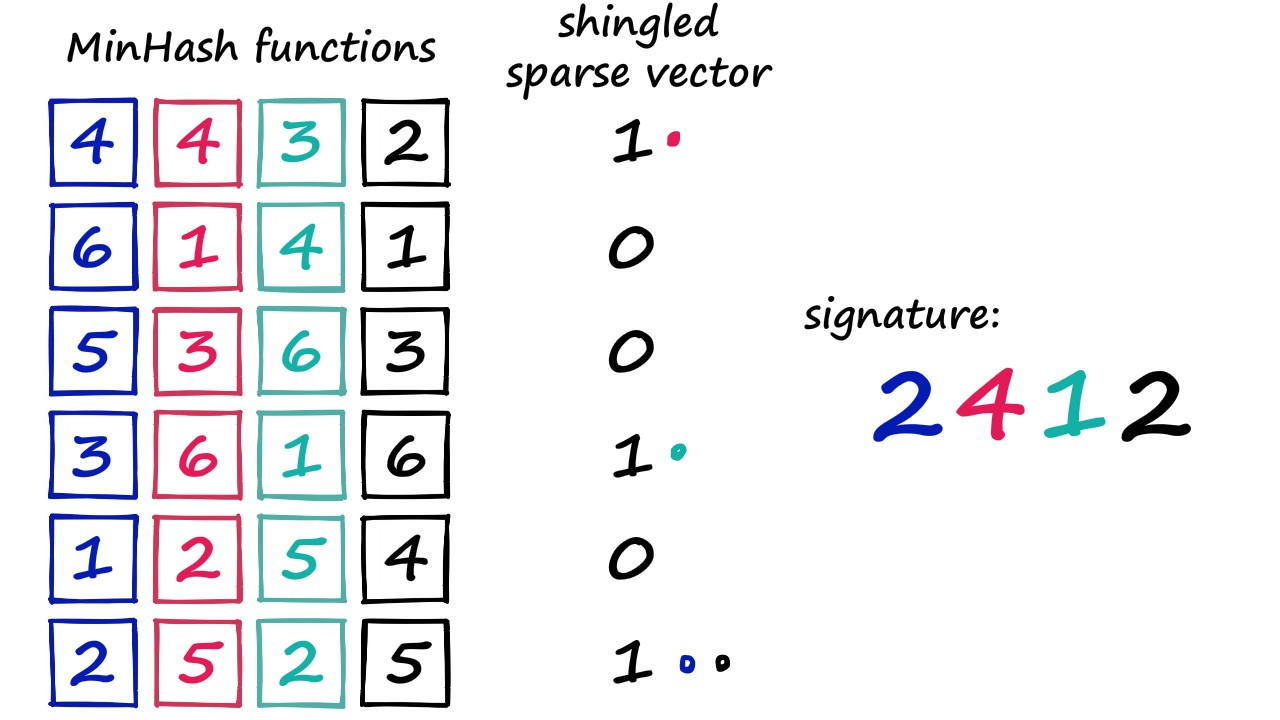

In [ ]:
# st = time.time()

# arr = minhash_arr(vocab, resolution)

# signatures = []
# for vector in tqdm(shingles_1hot):
#     signatures.append(get_signature(arr, vector))

# # merge signatures into single array
# # print("vector stacking.......")
# signatures = np.stack(signatures)

# et = time.time()

#print('Execution time:', et-st-0.5, 'seconds')
print("Min-hashed vector of the given dataset is a {0}x{1} matrix\n".format(signatures.shape[0], signatures.shape[1]))


### LSH

Finally, we move onto the LSH process.

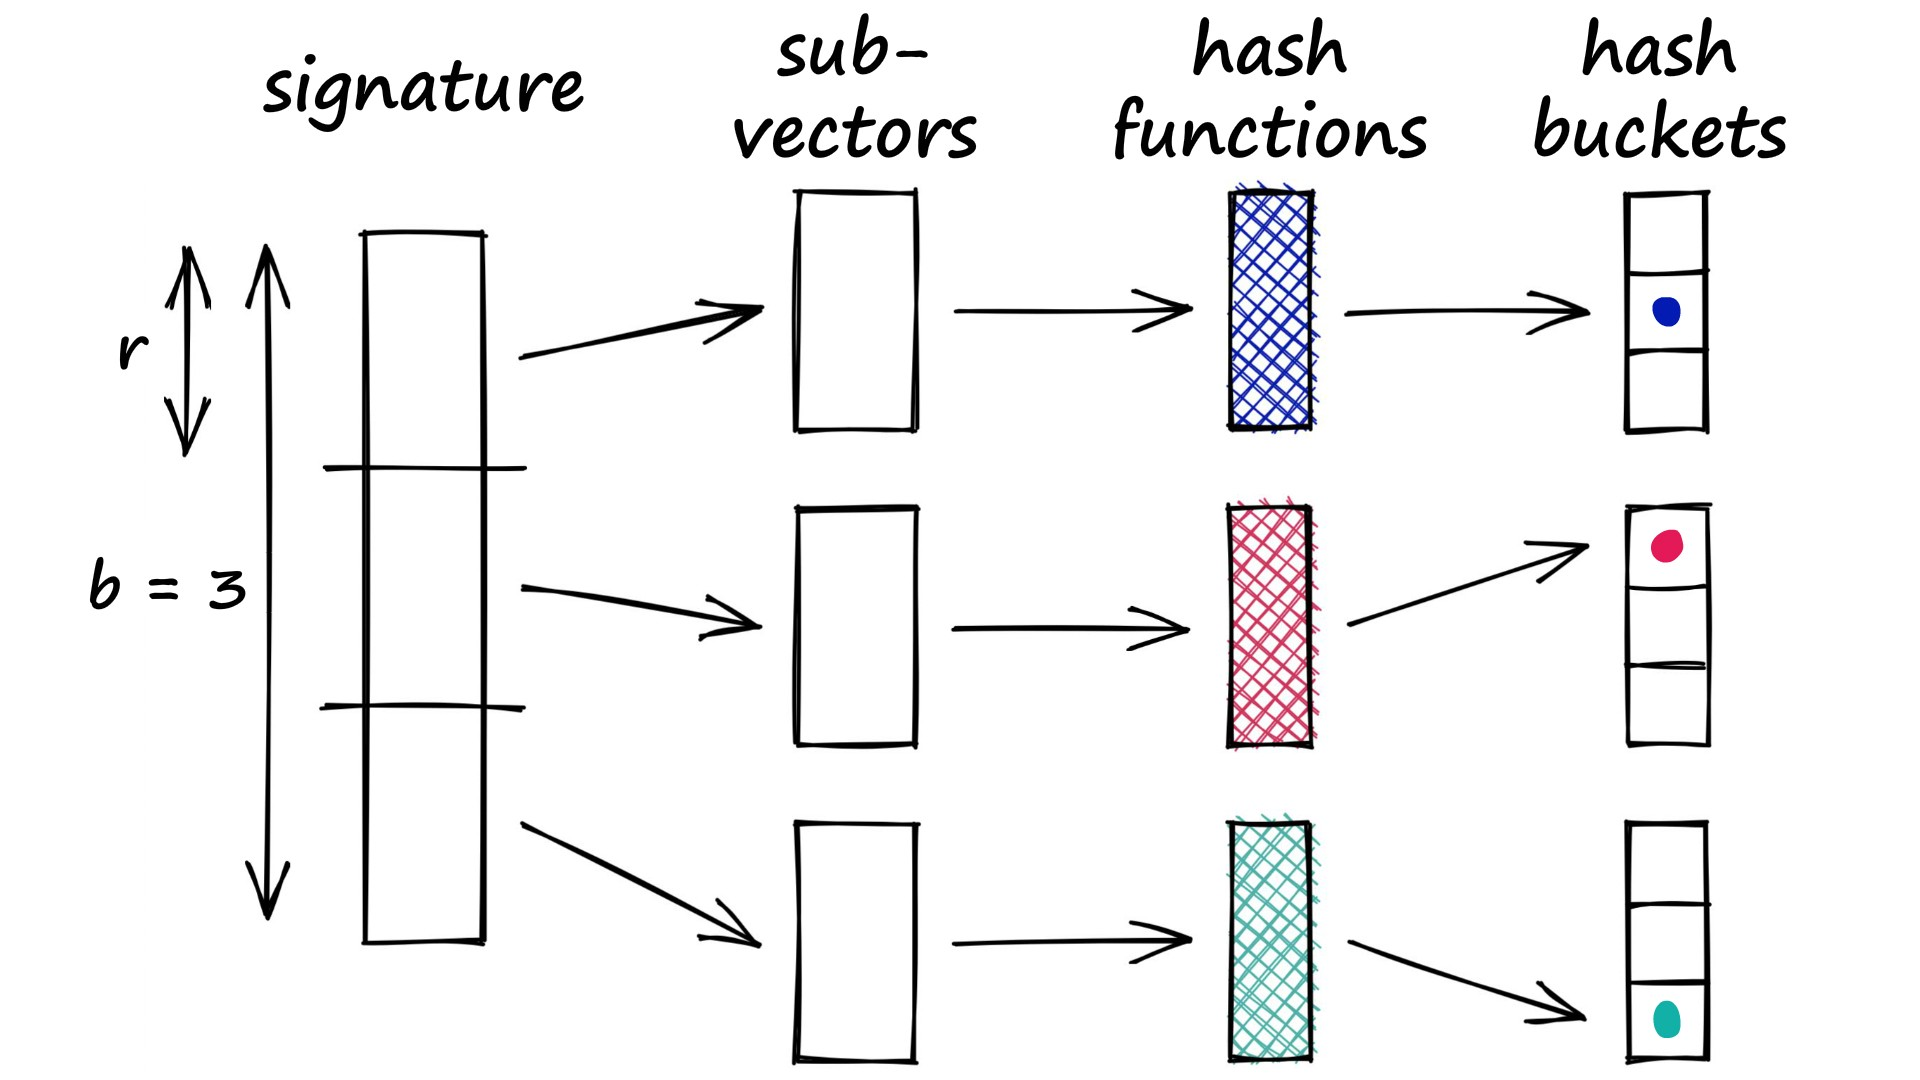

In [14]:
lsh = LSH(bk)
print("Dividing signature into buckets..........")

st = time.time()
for signature in tqdm(signatures):
    lsh.add_hash(signature)
et = time.time()
print('Execution time:', et-st, 'seconds')

In [15]:
# check similar pairs
candidate_pairs = lsh.check_candidates()

In [ ]:
(list(candidate_pairs)[:10])

In [ ]:
print(len(candidate_pairs))

<p>when the dataset contain 100000 rows</p>
<p>we needs to compare: $\frac{100000*(100000-1)}{2}$ times </p>

<p>However, indeedly we have less than 100,000 simlar pairs</p>

In the next step, I will try to optimize the clustering processing considering this

### Clustering Using KMeans

In [ ]:
# Function for calculating the distance between centroids
def jaccard(x,y):
    """A function for finding the similarity between two vectors"""
    # x is the data
    # y is the centroid
    similar = (x==y)
    intersection = np.count_nonzero(similar==True, axis=1)
    return intersection/x.shape[1]

def get_distances(centroid, points):
    """Returns the distance the centroid is from each data point in points."""
    return np.linalg.norm(points - centroid, axis=1)

def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected points from points."""
    return points[np.random.randint(points.shape[0], size=k)]

def jaccard_based_kmeans(signatures, k, maxiter):
    
    st = time.time()
    # Initialize our centroids by picking random data points
    centroids = initialize_clusters(signatures, k)
    # Initialize the vectors in which we will store the
    # assigned classes of each data point and the
    # calculated distances from each centroid
    classes = np.zeros(signatures.shape[0], dtype=np.float64)
    distances = np.zeros([signatures.shape[0], k], dtype=np.float64)

    # Loop for the maximum number of iterations
    for j in range(maxiter):
        if j%5==0:
            print("Iteration {0} of jaccard-based kmeans...........".format(j))
        # Assign all points to the nearest centroid
        for i, c in enumerate(centroids):
            distances[:, i] = jaccard(signatures, c)

        # Determine class membership of each point
        # by picking the closest centroid
        classes = np.argmax(distances, axis=1)

        # Update centroid location using the newly
        # assigned data point classes
        for c in range(k):
            freq_matrix = signatures[classes == c].transpose()
            centroids[c] = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in freq_matrix])
    
    et = time.time()
    
    print('Execution time:', et-st, 'seconds\n\n')
    for i in range(k):
        print("Clustering {0} take part in {1}% of the data".format(i, np.count_nonzero(classes==i)*100/signatures.shape[0]))
    
    
    return classes

In [ ]:
"""
Setting Paramters for K-means clustering
k: cluster number
maxiter: the times of iterations in K-means
signature: the LSH matrix
"""

k = 2
maxiter = 300

In [ ]:
classes = jaccard_based_kmeans(signatures, k, maxiter)

### Compression as string list

def gzip_compression(sList, path):
    with open(path,'wb') as f:
        for _ in tqdm(sList):
            compressed_value = gzip.compress(bytes(_, 'utf-8'))
            f.write(compressed_value)

def lz4_compression(sList, path):
    with open(path,'wb') as f:
        for _ in sList:
            input_data = _.encode('utf-8')
            compressed_value = lz4.frame.compress(input_data)
            f.write(compressed_value)

### Compression as a whole string

In [ ]:
def gzip_compression(s, path):
    with open(path,'wb') as f:
        compressed_value = gzip.compress(bytes(s, 'utf-8'))
        f.write(compressed_value)

In [ ]:
file_name = 'imdb'

with open(file_name +".txt", 'w') as f:
    for sentence in sentences:
        f.write(sentence)

In [ ]:
for i in range(k):
    loc = np.where(classes == i)[0]
    cs = [sentences[idx] for idx in loc]
    #print(df[column][loc][0])
    #loc = list(range(int(i*999990/72), int((i+1)*999990/72)))
    cluster_sentence = "".join(cs)
    cluster_file_name = file_name+str(i)+".txt"
    gzip_compression(cluster_sentence, cluster_file_name)
    cluster_size = os.stat(cluster_file_name).st_size / (1024*1024)
    
    cluster_file_full_name = file_name+str(i)+"full.txt"
    with open(cluster_file_full_name, 'w') as f:
        for _ in cs:
            f.write(_)
    cluster_size_full = os.stat(cluster_file_full_name).st_size / (1024*1024)
    
    print(i, cluster_size_full/cluster_size)